### **Problem Statement**


- Predicting student performance (Pass/Fail) based on student background and parental education.

#### **Why?**
- Improved predictions can help target students who need additional support


#### **Workflow**
1. **Baseline Model:** Logistic Regression
2. **Random Forest:** Add complexity to capture non-linear relationships
3. **Gradient Boosting:** Test an advanced model for higher accuracy

**Import Libraries**

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

In [186]:
# # mac
# data = pd.read_csv('/Users/azel/Documents/GitHub/Azel-s-DAC-Curriculum/Internal-Project/Students_Performance.csv') 

#windows
data = pd.read_csv('C:/Users/azelt/OneDrive/Documents/GitHub/Azel-s-DAC-Curriculum/Internal-Project/Students_Performance.csv') 

### **Average, Grade, and Status Columns**

In [187]:
# average score
data['average score'] = (data['math score'] + data['reading score'] + data['writing score']) / 3

# grade system
def grade_system(score):
    if score >= 70: return "First Class Honours"
    elif score >= 60: return "Second Upper Class Honours"
    elif score >= 50: return "Second Lower Class Honours"
    elif score >= 40: return "Third Class Honours"
    else: return "Fail"

data['grade'] = data['average score'].apply(grade_system)

In [188]:
# set Second Upper Class Honours as "Pass"
data['status'] = data['average score'].apply(lambda x: 'Fail' if x < 60 else 'Pass')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score,grade,status
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,First Class Honours,Pass
1,female,group C,some college,standard,completed,69,90,88,82.333333,First Class Honours,Pass
2,female,group B,master's degree,standard,none,90,95,93,92.666667,First Class Honours,Pass
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,Third Class Honours,Fail
4,male,group C,some college,standard,none,76,78,75,76.333333,First Class Honours,Pass


### **Check Class Distribution**

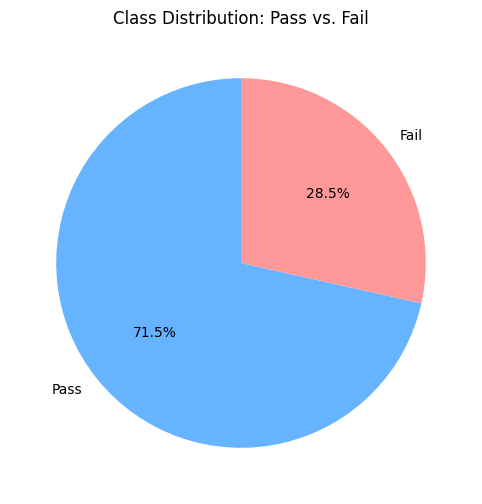

In [189]:
# counts the occurrences of each class in 'status' column (Pass/Fail)
class_counts = data['status'].value_counts()

# define labels and sizes for the pie chart
labels = class_counts.index
sizes = class_counts.values

# create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution: Pass vs. Fail')
plt.show()

#### **Observation**:
The dataset is imbalanced, with 71.5% of students labeled as 'Pass' and only 28.5% labeled as 'Fail.

#### **Implications**:
- This imbalance could bias the model towards predicting the majority class ('Pass') more often, leading to poor performance in identifying the minority class ('Fail').
- Class imbalance is particularly problematic in this case as the minority class ('Fail') is critical to identify.

### ***Pre-process the Data***

In [190]:
ml_data = data.copy()

In [191]:
# drop unnecessary columns
ml_data.drop(columns=["math score", "reading score", "writing score", "grade", "average score"], inplace=True)
ml_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,status
0,female,group B,bachelor's degree,standard,none,Pass
1,female,group C,some college,standard,completed,Pass
2,female,group B,master's degree,standard,none,Pass
3,male,group A,associate's degree,free/reduced,none,Fail
4,male,group C,some college,standard,none,Pass


In [192]:
# one-hot encode categorical features
categorical_features = ['gender', 'race/ethnicity', 'lunch', 'test preparation course', 'status']
ml_data_encoded = pd.get_dummies(ml_data, columns=categorical_features, drop_first=True)
ml_data_encoded.head()

,parental level of education,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_standard,test preparation course_none,status_Pass
0,bachelor's degree,False,True,False,False,False,True,True,True
1,some college,False,False,True,False,False,True,False,True
2,master's degree,False,True,False,False,False,True,True,True
3,associate's degree,True,False,False,False,False,False,True,False
4,some college,True,False,True,False,False,True,True,True


In [193]:
# define the order of categories for the 'parental level of education' column
education_order = [[
    "some high school", # 0 (lowest rank)
    "high school",      # 1
    "some college",     # 2
    "associate's degree", # 3
    "bachelor's degree",  # 4
    "master's degree",    # 5 (highest rank)
]]

#ordinal encoder encodes categorical data into integers while preserving a specified order.
ordinal_encoder = OrdinalEncoder(categories=education_order)

ml_data_encoded["parental level of education"] = ordinal_encoder.fit_transform(ml_data_encoded[["parental level of education"]])
ml_data_encoded.head()

,parental level of education,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_standard,test preparation course_none,status_Pass
0,4.0,False,True,False,False,False,True,True,True
1,2.0,False,False,True,False,False,True,False,True
2,5.0,False,True,False,False,False,True,True,True
3,3.0,True,False,False,False,False,False,True,False
4,2.0,True,False,True,False,False,True,True,True


#### ***Define Features & Target Variables***

In [194]:
# define the features and target variable
X = ml_data_encoded.drop(columns = ["status_Pass"])
y = ml_data_encoded["status_Pass"]

# split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### ***Apply SMOTE***

In [195]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original Class Distribution in Training Data:")
print(y_train.value_counts())
print()
print("Resampled Class Distribution After SMOTE:")
print(y_train_smote.value_counts())

Original Class Distribution in Training Data:
status_Pass
True     572
False    228
Name: count, dtype: int64

Resampled Class Distribution After SMOTE:
status_Pass
False    572
True     572
Name: count, dtype: int64


The training data is now balanced after applying SMOTE.

### **Logistic Regression**
- The task is a classification problem: predicting whether a student 'Passes' of 'Fails', which is a  binary outcome (0 or 1).
- Logistic Regression is designed to handle this type of problem by modeling probabilities and using a sigmoid function to produce binary predictions.

#### **Parameters:**
- **C:** controls the regularization strength in Logistic Regression.
  - A smaller value of C applies stronger regularization, which discourages overfitting.
  - A larger value of C applies weaker regularization, allowing the model to better fit complex patterns in the data.
- **penalty 'l1' & 'l2':**
  - l1 works better when the dataset has many irrelevant features.
  - l2 works better when the dataset has correlated or all-important features.
- **solver :** specifies the algorithm used to optimize the Logistic Regression model.
  - supports both l1 (Lasso) and l2 (Ridge) regularization penalties.

In [196]:
# define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2 penalties
}

# setup the model
logreg = LogisticRegression(class_weight= 'balanced', random_state=42)

# GridSearchCV
logreg_cv = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1')
logreg_cv.fit(X_train_smote, y_train_smote)

# check the Best Parameters and Best Score
print("Best Parameters: " + str(logreg_cv.best_params_))
print("Best Score: " + str(logreg_cv.best_score_)) # best cross-validated accuracy score

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.6843488117738843


In [197]:
# the accuracy of the model on the training data.
logreg_training_accuracy = logreg_cv.score(X_train, y_train)
# the accuracy of the model on the testing data
logreg_test_accuracy = logreg_cv.score(X_test, y_test)

print(f"Training Accuracy: {logreg_training_accuracy}")
print(f"Test Accuracy: {logreg_test_accuracy}")

Training Accuracy: 0.7431372549019608
Test Accuracy: 0.7003891050583657


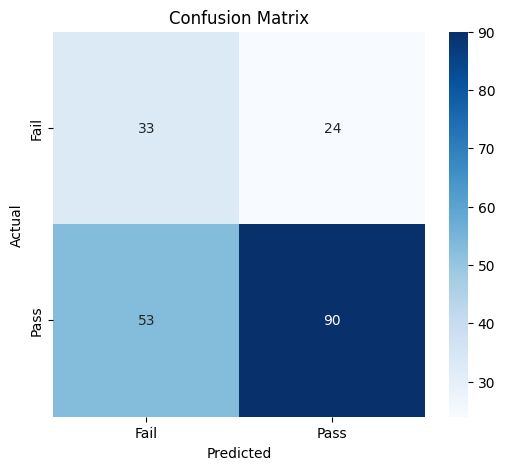

Classification Report:
              precision    recall  f1-score   support

       False       0.38      0.58      0.46        57
        True       0.79      0.63      0.70       143

    accuracy                           0.61       200
   macro avg       0.59      0.60      0.58       200
weighted avg       0.67      0.61      0.63       200



In [198]:
# predict on test data
y_pred = logreg_cv.best_estimator_.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


# plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


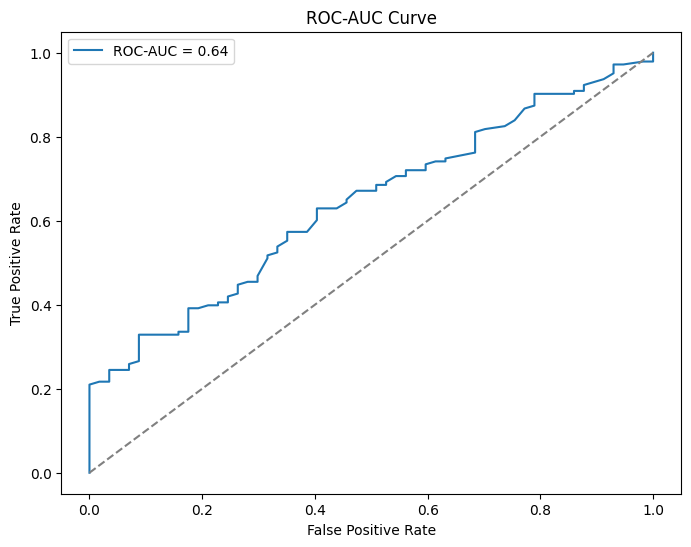

In [199]:
# predict probabilities
y_prob = logreg_cv.best_estimator_.predict_proba(X_test)[:, 1]

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

### ***What This Graph Tells Us***

- The current model has moderate performance at distinguishing between "Pass" or "Fail" with an AUC of 0.64. 
- The curve is not very far above the diagonal, which indicates the model struggles slightly to identify some positives or negatives correctly.

==================================================================================================================================================

### ***Random Forest Classifier***
Random Forest is a non-linear ensemble method that uses multiple decision trees to improve predictions.

**Advantages of using Random Forest**
- **Captures Non-Linear Pattern:** does not assume a linear relationship between features and the target.
- **Handles Feature Interactions:** automatically considers interactions between features.
- **Robust to Overfitting:** by averaging predictions from multiple trees, Random Forest reduces overfitting.
- **Handles Imbalanced Data:** allows us to set class_weight='balanced' to focus on minority class ('Fail').
- **Feature Importance:** it identifies the most important features, which helps in feature selection and interpretation.

#### **Parameters:**
- **n_estimators:** number of trees in the forest.
  - A higher value often improves performance but increases computation time.
- **max_depth:** maximum depth of each tree.
  - Restricting depth prevents overfitting, especially for small datasets.
- **min_samples_leaf :** minimum no. of samples required to be at a leaf node.
  - ensures splits aren't based on tiny subsets of data.
- **class weight :** adjusts for class imbalance.

In [200]:
# define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample'] 
}

# set up the model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1) # enable parallel processing with 'n_jobs=-1'
rf_cv.fit(X_train_smote, y_train_smote)

# best parameters and score
print("Best Parameters:", rf_cv.best_params_)
print("Best F1-Score:", rf_cv.best_score_)



Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-Score: 0.7046457929507037


Classification Report - Tuned Random Forest:
              precision    recall  f1-score   support

       False       0.34      0.54      0.42        57
        True       0.76      0.57      0.65       143

    accuracy                           0.56       200
   macro avg       0.55      0.56      0.53       200
weighted avg       0.64      0.56      0.59       200



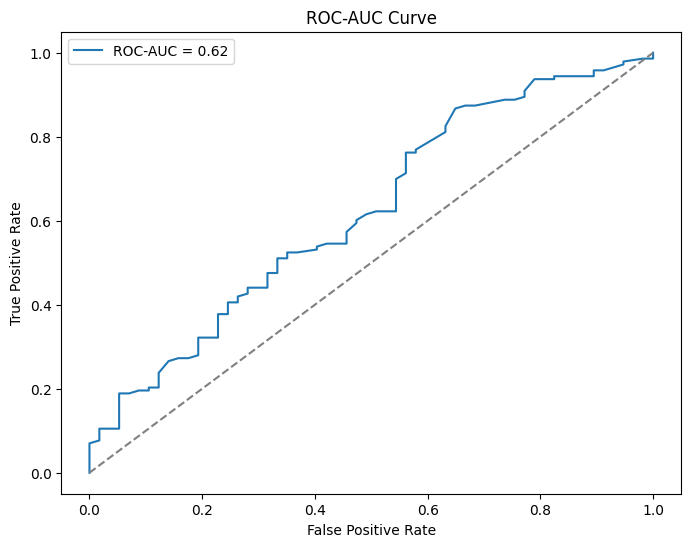

In [201]:
# evaluate the best model on the test set
y_pred_rf = rf_cv.best_estimator_.predict(X_test)
y_prob_rf = rf_cv.best_estimator_.predict_proba(X_test)[:, 1]

# classification report
print("Classification Report - Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

### ***What This Graph Tells Us***

- The current model has moderate performance at distinguishing between "Pass" or "Fail" with an AUC of 0.62. 
- The curve is only marginally above the diagonal line (random classifier).
- This means that while the model has learned some patterns, it is not performing well enough to confidently identify the two classes.

### ***Feature Importance***

Top Features by Importance:
                        Feature  Importance
0   parental level of education    0.423219
7  test preparation course_none    0.231465
6                lunch_standard    0.139715
1                   gender_male    0.078970
2        race/ethnicity_group B    0.034697
3        race/ethnicity_group C    0.032930
4        race/ethnicity_group D    0.031832
5        race/ethnicity_group E    0.027172


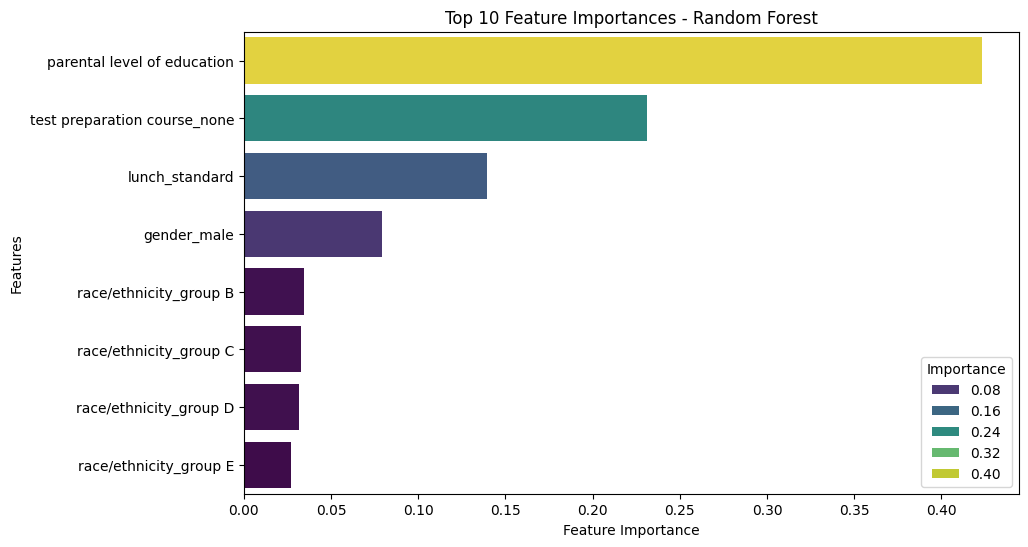

In [ ]:
# calculate feature importance from RF
importances = rf.feature_importances_
features = X_train.columns

# create  df for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# display the top features
print("Top Features by Importance:")
print(importance_df.head(10))  # Show top 10 features

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',hue='Importance', data=importance_df.head(10), palette='viridis')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


=================================================================================================================

### ***Gradient Boosting***
Gradient Boosting is another tree-based ensemble method, but unlike Random Forest, it builds trees sequentially. 

**Advantages of using Gradient Boosting**
- **Better Accuracy:** outperforms RF and LR by minimizing errors sequentially.
- **Focus on Hard-to-Classify Examples:** it corrects mistakes made by previous trees, giving greater focus to hard-to-classify samples.
- **Fine-Tuned Predictions:** tends to provide better performance in tasks when tuned properly.

#### **Parameters:**
- **n_estimators:** controls the number of boosting stages to be built.
  - A larger value  improves accuracy but increases computation time.
- **learning_rate:** controls the contribution of each tree to the overall model.
  - Smaller values improve performance but require more trees (n_estimators) to achieve the same result.
- **max_depth:** maximum depth of each tree.
  - Restricting depth prevents overfitting, especially for small datasets.
- **min_samples_split :** minimum no. of samples required to split an internal node.
  - Larger values prevent small splits and help reduce overfitting.
- **min_samples_leaf :** minimum no. of samples required to be at a leaf node.
  - ensures splits aren't based on tiny subsets of data.
- **subsample :** Fraction of samples used to fit each tree.
  - Values less than 1.0 (e.g., 0.8) act as a form of regularization by introducing randomness.

In [202]:
# define the parameter grid for GB
param_grid = {
    'n_estimators': [100],       
    'learning_rate': [0.01, 0.05, 0.1],    
    'max_depth': [3, 5, 7],                
    'min_samples_split': [2, 5, 10],       
    'subsample': [0.8, 1.0]                
}

# setup the model
gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV
gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
gb_cv.fit(X_train_smote, y_train_smote)

# best parameters and score
print("Best Parameters:", gb_cv.best_params_)
print("Best F1-Score from Cross-Validation:", gb_cv.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Best F1-Score from Cross-Validation: 0.7173706058283329


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

       False       0.38      0.53      0.44        57
        True       0.78      0.65      0.71       143

    accuracy                           0.61       200
   macro avg       0.57      0.59      0.57       200
weighted avg       0.66      0.61      0.63       200



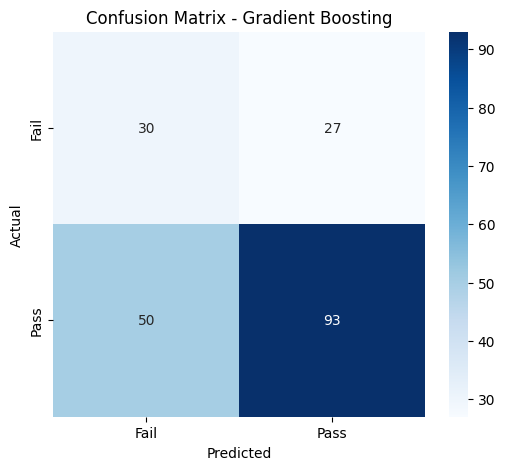

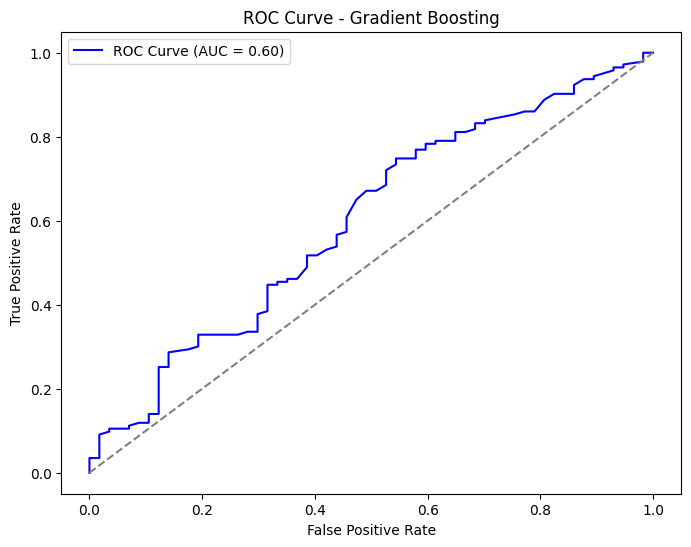

ROC-AUC Score: 0.60


In [203]:
# evaluate the best model on the test set
best_gb = gb_cv.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

# classification report
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gb))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)
roc_auc = roc_auc_score(y_test, y_prob_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.2f}")

### ***What This Graph Tells Us***

- The current model has moderate performance at distinguishing between "Pass" or "Fail" with an AUC of 0.61. 
- The curve is not very far from the diagonal line (random classifier), which implies that the model is weak in separating the two classes.

=================================================================================================================

### **Comparison between the 3 models**

Model Comparison Results:
                 Model  Accuracy  F1-Score  Precision    Recall   ROC-AUC
0  Logistic Regression     0.615  0.700389   0.789474  0.629371  0.639553
1        Random Forest     0.605  0.697318   0.771186  0.636364  0.603668
2    Gradient Boosting     0.615  0.707224   0.775000  0.650350  0.599313


<Figure size 1000x600 with 0 Axes>

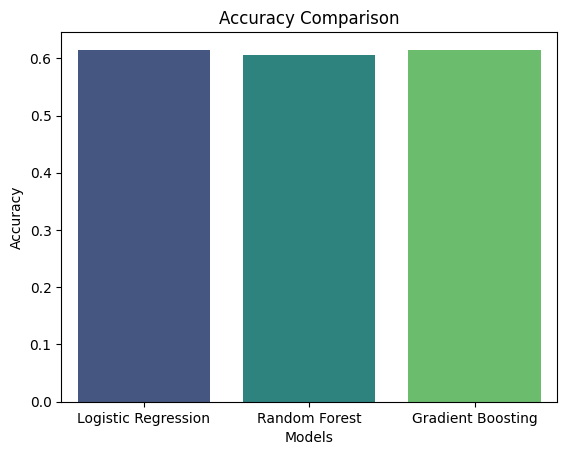

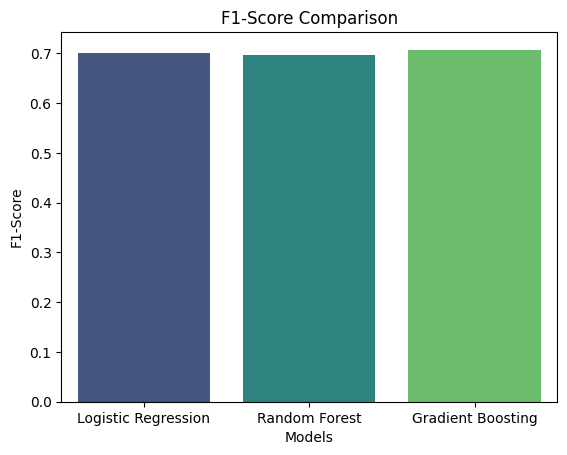

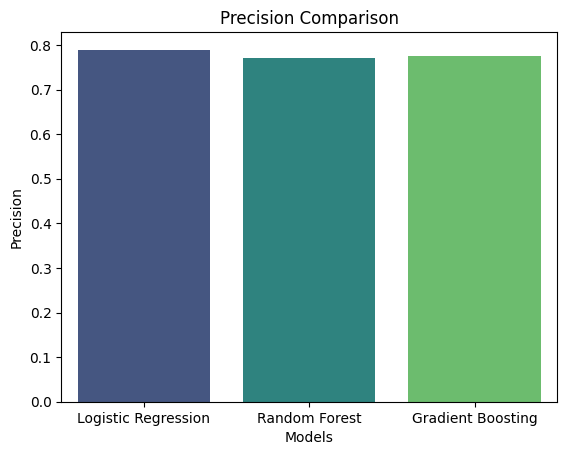

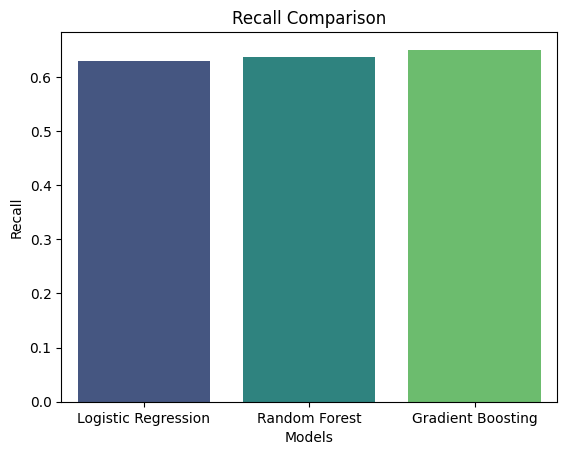

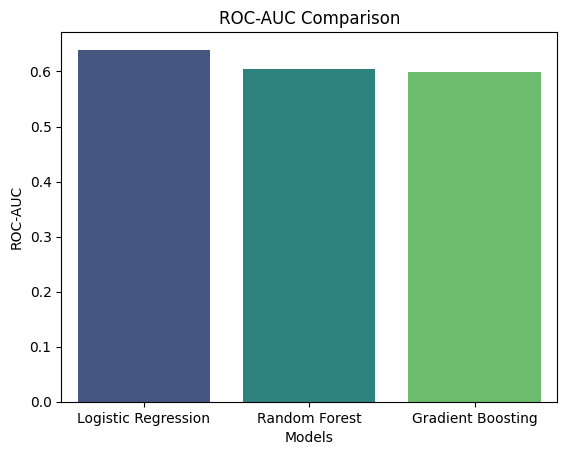

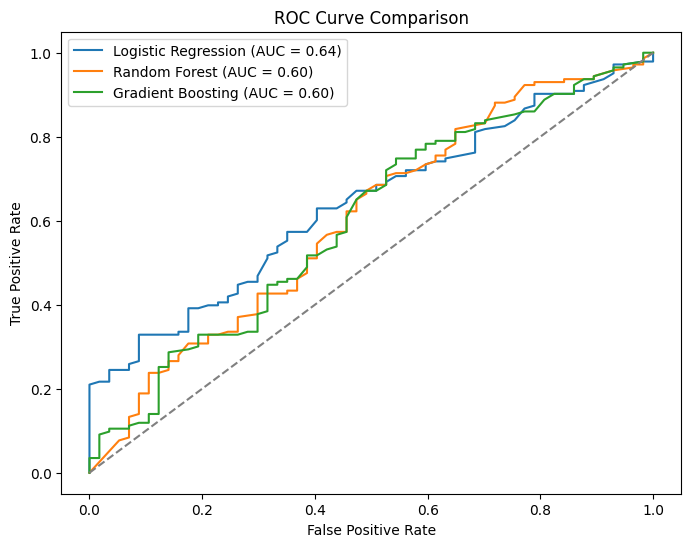

In [207]:
# Placeholder for model metrics
results = []

# ===================== Logistic Regression =====================
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=1, random_state=42)
logreg.fit(X_train_smote, y_train_smote)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'F1-Score': f1_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'ROC-AUC': roc_auc_score(y_test, y_prob_logreg)
})

# ===================== Random Forest =====================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf)
})

# ===================== Gradient Boosting =====================
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train_smote, y_train_smote)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

results.append({
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'F1-Score': f1_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb),
    'Recall': recall_score(y_test, y_pred_gb),
    'ROC-AUC': roc_auc_score(y_test, y_prob_gb)
})

# ===================== Results DataFrame =====================
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df)

# ===================== Visualization =====================
# Bar Plot for Comparison
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
plt.figure(figsize=(10, 6))

for metric in metrics:
    plt.figure()
    sns.barplot(x='Model', y=metric, hue= 'Model', data=results_df, palette='viridis', legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Models')
    plt.show()

# ===================== ROC Curve Comparison =====================
plt.figure(figsize=(8, 6))

# ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = {:.2f})'.format(results_df.loc[0, 'ROC-AUC']))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(results_df.loc[1, 'ROC-AUC']))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = {:.2f})'.format(results_df.loc[2, 'ROC-AUC']))

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### **Key Observations**
- Logistic Regression seems to edge out the other models slightly in terms of ROC-AUC, Precision and Recall.
- RF and GB have very similar results.
- The difference across metrics are minimal, meaning no model has a clear advantage.

### **Confusion Matrix Analysis**
Focus on how each model handles the minority class ("Fail")

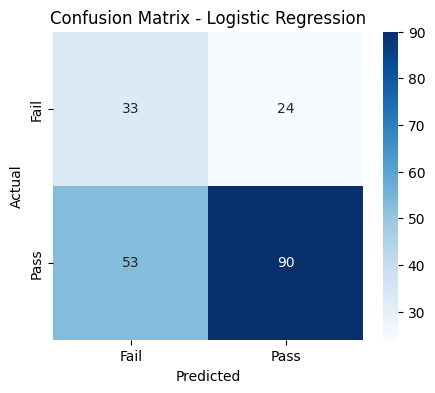

Logistic Regression Recall (Fail): 0.63


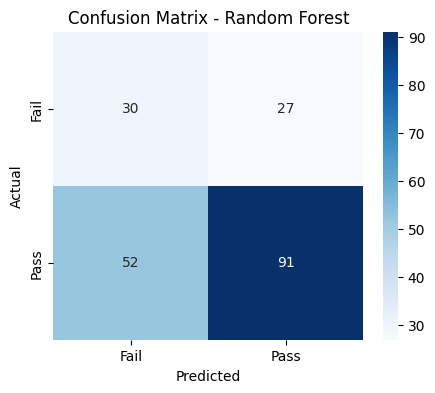

Random Forest Recall (Fail): 0.64


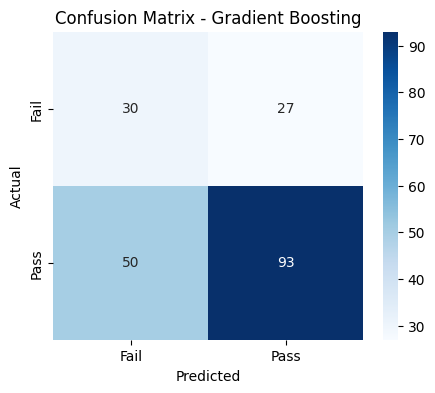

Gradient Boosting Recall (Fail): 0.65


In [208]:

# ==================== Logistic Regression ====================
y_pred_logreg = logreg.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap="Blues", xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(f"Logistic Regression Recall (Fail): {recall_logreg:.2f}")

# ==================== Random Forest ====================
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(f"Random Forest Recall (Fail): {recall_rf:.2f}")

# ==================== Gradient Boosting ====================
y_pred_gb = gb.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap="Blues", xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(f"Gradient Boosting Recall (Fail): {recall_gb:.2f}")


### **Key Observations**
- Gradient Boosting identifies the most "Fail" cases out of the 3 models.
- This makes GB the best model for handling the minority class.